
# Embeddings & Cosine Similarity: A Hands-On Mini‑Lab

**Target audience:** Senior (4th‑year) CS students  
**Runtime:** CPU‑friendly, self‑contained

### Learning Objectives
- Explain what a *sentence embedding* is (a high‑dimensional numeric representation of text).
- Compute and interpret **cosine similarity**.
- Use a compact sentence embedding model to embed sentences and queries.
- Visualize embeddings in 2D with **UMAP** (and optional **PCA**) and relate clusters to semantic similarity.



## Setup & Imports
This cell installs and imports the libraries we need. Re‑run it if you encounter import errors.


In [1]:

# If needed (safe to re-run)
# %pip -q install sentence-transformers umap-learn scikit-learn matplotlib numpy


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA  # used only in commented-out code
import umap
import random

# Reproducibility: note UMAP remains partly stochastic, but this helps
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("Libraries imported.")


Libraries imported.



## Mini‑Primer: Embeddings & Cosine Similarity

A **sentence embedding** maps text to a fixed‑length numeric vector in a high‑dimensional space. Similar meanings are intended
to be **nearby** in that space.

**Cosine similarity** between vectors a and b is:

cosine_sim(a, b) = (a · b) / (||a|| * ||b||)

It measures the angle between vectors and is **scale‑invariant**, making it a popular choice for comparing embeddings.



## Create Example Sentences
We’ll use **10** short sentences across several themes.


In [3]:

sentences = [
    "The chef simmered tomatoes to make a rich pasta sauce.",
    "Our basketball team practiced free throws late into the night.",
    "I booked a flight to Tokyo for a two-week adventure.",
    "She trained a neural network to classify images of leaves.",
    "The guitarist improvised a solo during the live performance.",
    "We optimized the database queries to reduce latency.",
    "Hiking the alpine trail offered breathtaking views of the valley.",
    "The lecture covered recursion and its relation to stack frames.",
    "He brewed a dark roast coffee with a French press.",
    "They deployed the web app using continuous integration."
]

for i, s in enumerate(sentences):
    print(f"{i:2d}: {s}")


 0: The chef simmered tomatoes to make a rich pasta sauce.
 1: Our basketball team practiced free throws late into the night.
 2: I booked a flight to Tokyo for a two-week adventure.
 3: She trained a neural network to classify images of leaves.
 4: The guitarist improvised a solo during the live performance.
 5: We optimized the database queries to reduce latency.
 6: Hiking the alpine trail offered breathtaking views of the valley.
 7: The lecture covered recursion and its relation to stack frames.
 8: He brewed a dark roast coffee with a French press.
 9: They deployed the web app using continuous integration.



## Load a Compact Embedding Model

Choose a model to create sentence embeddings.  Essentially a multidimensional array of floats which represent the meaning of a chunk of text (can use images, audio as well). The open source <a href="https://www.sbert.net/">sentence transformers library</a> is designed for this. See the <a href="https://huggingface.co/spaces/mteb/leaderboard">MTEB leaderboard</a> for embedding model comparisons.

There are other embedding models, for instance <a href="https://platform.openai.com/docs/guides/embeddings/embedding-models">OpenAI</a> (but you pay per token and its proprietary).

We’ll use `sentence-transformers/all-MiniLM-L6-v2`, a small, fast model that returns **384‑dimensional** embeddings.


In [4]:
#go to the MTEB leaderboard to choose a model
# https://huggingface.co/spaces/mteb/leaderboard
# it looks like Qwen/Qwen3-Embedding-0.6B is doing well 
#https://huggingface.co/Qwen/Qwen3-Embedding-0.6B
# model_name = "Qwen/Qwen3-Embedding-0.6B"

model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)
print(f"Loaded model: {model_name}")


Loaded model: sentence-transformers/all-MiniLM-L6-v2



## Embed the 10 Sentences
We’ll normalize the embeddings, which pairs nicely with cosine similarity.


In [5]:

sentence_embeddings = model.encode(
    sentences, convert_to_numpy=True, normalize_embeddings=True
)
print("Embeddings shape:", sentence_embeddings.shape)  # Expect (10, 384)


Embeddings shape: (10, 384)



## Create Two Questions (Queries)
Each question should relate to at least some sentences above.


In [6]:

questions = [
    "Which sentence mentions international travel?",
    "Which sentence discusses training a neural network?"
]

for i, q in enumerate(questions):
    print(f"{i}: {q}")


0: Which sentence mentions international travel?
1: Which sentence discusses training a neural network?



## Embed the Questions
We’ll embed and normalize the questions just like the sentences.


In [7]:

question_embeddings = model.encode(
    questions, convert_to_numpy=True, normalize_embeddings=True
)
print("Question embeddings shape:", question_embeddings.shape)  # Expect (2, 384)


Question embeddings shape: (2, 384)



## Cosine Similarity Search
For each question, compute cosine similarity against all 10 sentences and report the **top‑1** result (plus a top‑3 table).
Cosine similarity ranges from **-1** to **1** (larger is more similar).


In [8]:

def search_top_k(query_emb, corpus_embs, k=3):
    """
    Returns indices and scores of top-k most similar sentences.
    """
    sims = cosine_similarity(query_emb.reshape(1, -1), corpus_embs).flatten()
    top_idx = np.argsort(-sims)[:k]  # sort descending
    return top_idx, sims[top_idx], sims

for qi, q in enumerate(questions):
    print(f"\nQuestion {qi}: {q}")
    top_idx, top_scores, sims = search_top_k(question_embeddings[qi], sentence_embeddings, k=3)
    
    # Best (top-1)
    best_idx = int(top_idx[0])
    best_score = float(top_scores[0])
    print(f"Best match -> [{best_idx}] {sentences[best_idx]}  (cosine={best_score:.3f})")
    
    # Top-3 table
    print("Top-3 matches: (index | cosine)")
    for idx, score in zip(top_idx, top_scores):
        print(f"  {int(idx):2d} | {score:.3f}")



Question 0: Which sentence mentions international travel?
Best match -> [2] I booked a flight to Tokyo for a two-week adventure.  (cosine=0.367)
Top-3 matches: (index | cosine)
   2 | 0.367
   7 | 0.087
   6 | 0.081

Question 1: Which sentence discusses training a neural network?
Best match -> [3] She trained a neural network to classify images of leaves.  (cosine=0.471)
Top-3 matches: (index | cosine)
   3 | 0.471
   0 | 0.217
   7 | 0.213



## 2D Visualization with UMAP (and optional PCA)
The function below projects sentence embeddings into 2D with UMAP and, if a question is provided, projects that query too.


In [9]:

def plot_embeddings_2d_umap(sentence_embeddings, sentences, question_embedding=None, question_text=None, random_state=42):
    """
    Projects sentence embeddings to 2D via UMAP and plots them.
    If question_embedding is provided, project it with the same reducer and plot it in a different marker.
    """
    reducer = umap.UMAP(n_components=2, random_state=random_state)
    sent_2d = reducer.fit_transform(sentence_embeddings)

    plt.figure(figsize=(7, 6))
    plt.scatter(sent_2d[:, 0], sent_2d[:, 1], label="Sentences")
    for i in range(len(sentences)):
        # label by index to keep the plot readable
        plt.annotate(str(i), (sent_2d[i, 0], sent_2d[i, 1]), fontsize=9)

    if question_embedding is not None:
        q_2d = reducer.transform(question_embedding.reshape(1, -1))
        plt.scatter(q_2d[:, 0], q_2d[:, 1], marker="X", s=120, label="Question")
        if question_text:
            plt.title(f"UMAP of Sentences with Query: {question_text}")
    else:
        plt.title("UMAP of Sentence Embeddings")

    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend()
    plt.show()

# --- Optional PCA alternative (uncomment to use) ---
def plot_embeddings_2d_pca(sentence_embeddings, sentences, question_embedding=None, question_text=None, random_state=42):
    pca = PCA(n_components=2, random_state=42)
    sent_2d = pca.fit_transform(sentence_embeddings)
    plt.figure(figsize=(7, 6))
    plt.scatter(sent_2d[:, 0], sent_2d[:, 1], label="Sentences")
    for i in range(len(sentences)):
        plt.annotate(str(i), (sent_2d[i, 0], sent_2d[i, 1]), fontsize=9)
    if question_embedding is not None:
        q_2d = pca.transform(question_embedding.reshape(1, -1))
        plt.scatter(q_2d[:, 0], q_2d[:, 1], marker="X", s=120, label="Question")
        if question_text:
            plt.title(f"PCA of Sentences with Query: {question_text}")
    else:
        plt.title("PCA of Sentence Embeddings")
    plt.xlabel("PC-1"); plt.ylabel("PC-2")
    plt.legend()
    plt.show()



## Visualize Each Question
We’ll plot sentence embeddings in 2D with UMAP and overlay each query.
Before each plot, we print an **index → sentence** legend.

Keep in mind that we are reducing the dimensionality from the embedding size (384 for all-MiniLM-L6-v2) to 2 dimensions.  We will lose information so the projection may not line up with the cosign similarity pick. 


Index → Sentence legend:
[0] The chef simmered tomatoes to make a rich pasta sauce.
[1] Our basketball team practiced free throws late into the night.
[2] I booked a flight to Tokyo for a two-week adventure.
[3] She trained a neural network to classify images of leaves.
[4] The guitarist improvised a solo during the live performance.
[5] We optimized the database queries to reduce latency.
[6] Hiking the alpine trail offered breathtaking views of the valley.
[7] The lecture covered recursion and its relation to stack frames.
[8] He brewed a dark roast coffee with a French press.
[9] They deployed the web app using continuous integration.

Plotting for Question 0: Which sentence mentions international travel?


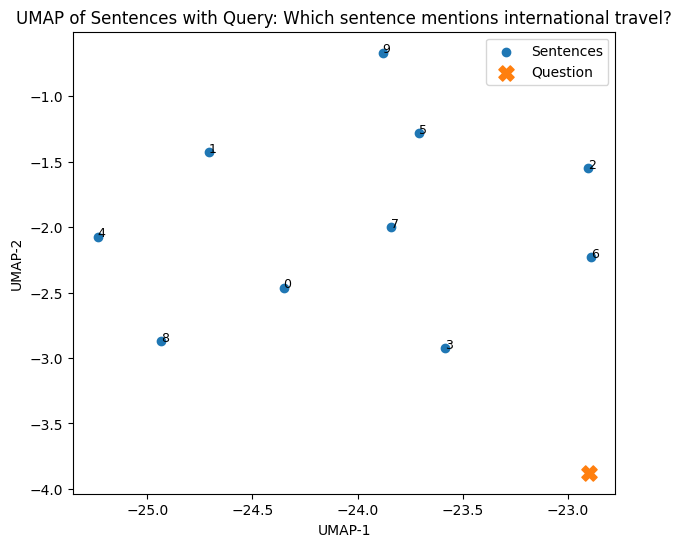


Plotting for Question 1: Which sentence discusses training a neural network?


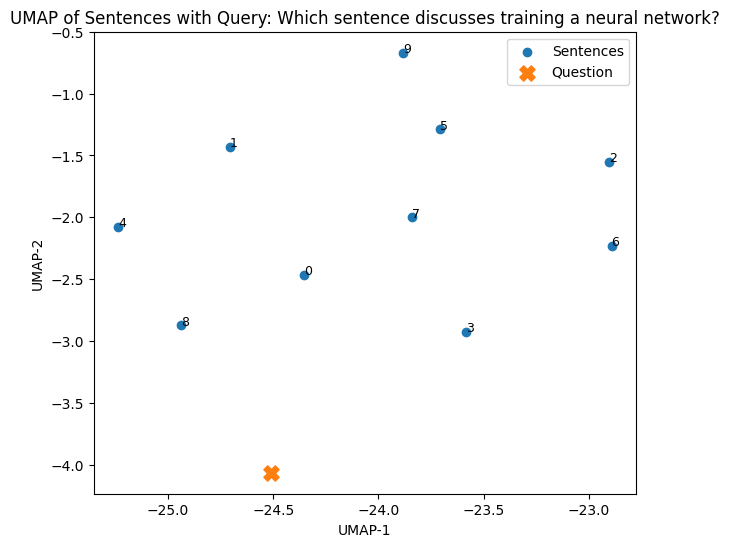

In [10]:

print("Index → Sentence legend:")
for i, s in enumerate(sentences):
    print(f"[{i}] {s}")
    
# Plot for each question
for qi, q in enumerate(questions):
    print(f"\nPlotting for Question {qi}: {q}")
    plot_embeddings_2d_umap(sentence_embeddings, sentences, question_embeddings[qi], q, random_state=SEED)
    # plot_embeddings_2d_pca(sentence_embeddings, sentences, question_embeddings[qi], q, random_state=SEED)




## Reflection
- Do the nearest sentences align with your intuition?
- What happens if you change the questions or add/remove sentences?
- Try toggling UMAP vs. PCA—does the 2D layout change your interpretation of neighborhood structure?



## (Optional) Exercises
1. Add 3 new sentences and a new query. Re‑run the similarity search.
2. Compare normalized vs. non‑normalized embeddings (predict how scores will change).
3. Try a different embedding model from the `sentence-transformers` library and compare results.
